# Getting the Data
The first step we should always do is download our dataset, I found this one to be the simplest one to start with.
This dataset comes from Google and was used in training the LookToListen Algorithm. Thanks to Mayur Newase for sharing this dataset in Kaggle.

You can download the dataset from Kaggle here https://www.kaggle.com/mayurnewase/audio-dataset/downloads/audio-dataset.zip/1

# Importing libraries and defining varaibles

This line lets up easily see images made in matplotlib as they are made. This helps us view the results and should always be put a the beginning of a Jupyter Project

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

We import all of the necesary libraries, if there is one that you don't have installed just add it in your pip or conda env.

In [47]:
import os
import numpy as np
from pathlib import Path
from shutil import copyfile
import random
import torch
from torch.utils.data import Dataset
import librosa
import librosa.display
import matplotlib.pyplot as plt
import matplotlib
from IPython.display import Audio
from PIL import Image
from tqdm import tqdm_notebook as tqdm

These are the paths to the dataset, I renamed mine to be called "Clean" but you can leave it as is if you want. Here we also define the Folder where we will store the audios with noise.

In [3]:
path_good   = Path("Clean")
path_crappy = Path("Noise")
path_crappy.mkdir(parents=True, exist_ok=True)

# "Crappify" Functions

This project follows the idea behind "crappify". This is esencially to take data that is of "good" quality (good resolution, has color, etc.) but is easy to transform into "bad" quality (lower resolution, gray-scale, etc.). This way we can make make our dataset starting from clean data and teaching the neural network to take the bad data and transform it to the good data.

In this case we will take audios and add noise to it, hoping that the NN can learn how to remove this type of noise.

### These functions makes random noise and adds it to the audios, you can play with the type of noise to best fit the noise that you have in real life. In this case we make our noise from a normal distribution. We add a multiplier to make sure that the noise doesn't completely shadow the original audio.

In [4]:
def crappy_name(good_name):
    good_name = good_name.relative_to(path_good)
    crappy_file = path_crappy/good_name
    crappy_file.parent.mkdir(parents=True, exist_ok=True)
    return crappy_file

def crappify(file, multiplier):
    crappy_file = crappy_name(file)
    
    clip, sample_rate = librosa.load(file, sr=None)
    
    noise = np.random.normal(0, 1, clip.shape)
    noise*= multiplier
    noise+= clip

    librosa.output.write_wav(crappy_file, noise, sample_rate, True)

We apply these functions on everyfile in our Dataset to create the "crappy" dataset.

In [5]:
clean_files = os.listdir(path_good)

In [6]:
if not(path_crappy.exists):
    multiplier = 0.005
    for file in clean_files:
        crappify(path_good/Path(file), multiplier)

In [7]:
noisy_files = os.listdir(path_crappy)

---------------------------------------------

# Audio to images

In the study of audio, it is pretty much accepted that the best way to work with these datasets is to transform the noise into an image. We will explain how this project works later, but for now just understand that there is a very clever mathmatical method on how to do this called Short Time Fourier Transforms (STFT), which is what we will be using.

The first function simply makes the name where we will be storing these images, in this case it will be in a new folder with "_image" at the end of the name. It stores it with the extension ".np" which is just one we made up for this activity.

The second function loads the audio and makes the Matrix from the stft function librosa has. After that we save the Matrix in its appropriate file name using the torch save function. In the commented line you can see an example of how to undo the STFT function, which is just Inverse STFT (or ISTFT)

In [8]:
def array_name(path:Path, from_clean:bool):
    if from_clean:
        folder_path = path_good
    else:
        folder_path = path_crappy
    newfolder_path = Path(folder_path.name+"_image")
    file_name = path.relative_to(folder_path)
    image_file = Path(newfolder_path/file_name)
    image_file.parent.mkdir(parents=True, exist_ok=True)
    return image_file.with_suffix(".np")

In [9]:
def audio_to_matrix(audiopath:Path, clean:bool, colormap="jet"):
    array_file = array_name(audiopath, clean)
    data, sample_rate = librosa.load(audiopath)

    stftMat = librosa.core.stft(data, center=True)
    #data2 = librosa.core.istft(stftMat)
    
    torch.save(stftMat, array_file)

In [10]:
for file in clean_files:
    audio_to_matrix(path_good/Path(file), clean=True)
    
for file in noisy_files:
    audio_to_matrix(path_crappy/Path(file), clean=False)

# STFT Function

Explaination of how the functions works

# Viewing an example

So one of the problems you might find in this method is that the variables will change depending on the "resolution" of the image when we decide to inverse the process. And you are right, but in practice it won't really affect much. Lets see how the data looks like.

We add one more function which allows us to view the Spectrogram of a certain file. At the same time we create our imageset for all files in the clean and noisy folders.

In [55]:
def plot_matrix(filepath:Path):
    data, sample_data = librosa.load(filepath)
    stftMat = librosa.core.stft(data, center=True)
    librosa.display.specshow(librosa.amplitude_to_db(stftMat,ref=np.max))
    plt.gca().set_axis_off()
    plt.margins(0.0)
    plt.savefig("image1.png", bbox_inches = 'tight', pad_inches = 0)

First we will copy the code in the function and test this our on one of our files, and at the end we will plot the Matrix with librosa display to see how our data looks like.

In [22]:
path_good

PosixPath('Clean')

In [20]:
clean_files[0]

'q_xZRLJIJrA.wav'

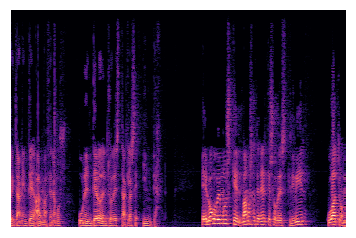

In [56]:
audiopath = Path("Clean_test/test.wav")

plot_matrix(audiopath)

Now since we have the original data and the reconstructed data, we might want to see just how much of a difference the limitation in resolution might make. We calculate the mean error of the absolute difference. There is a small error which is a drop in the quality, but it's less than 3.5*10**-9 and shouldn't represent that much of a difference.

In [16]:
data, sample_rate = librosa.load(audiopath)
stftMat = librosa.core.stft(data, center=True)
data2 = librosa.core.istft(stftMat)
np.mean(np.abs(data-data2))

2.3158917e-09

In [18]:
stftMat

array([[-1.04658209e-01+0.00000000e+00j, -8.30309466e-02+0.00000000e+00j,
        -1.01432372e-02+0.00000000e+00j, ...,
        -3.39405574e-02+0.00000000e+00j, -5.15944600e-01+0.00000000e+00j,
        -9.96852636e-01+0.00000000e+00j],
       [ 1.16818920e-01+4.93311988e-18j,  4.28514788e-03+1.72976125e-02j,
         3.60001400e-02+5.36858104e-02j, ...,
         6.09272942e-02-2.47619580e-03j, -3.37546766e-02-4.80541021e-01j,
         1.03668070e+00+3.30270431e-03j],
       [-1.62999764e-01-2.34026098e-16j,  1.22244261e-01+6.12965003e-02j,
        -4.42028418e-02-1.01189084e-01j, ...,
        -1.47238642e-01+3.70204076e-02j,  6.07418776e-01+4.23922241e-02j,
        -1.03253210e+00-6.20074011e-03j],
       ...,
       [ 3.46963294e-02-8.94998438e-17j, -1.73540283e-02-3.56655364e-05j,
        -1.29297245e-04-6.08655428e-05j, ...,
         1.03165796e-04-3.57019144e-06j, -2.08396604e-03-8.53695165e-05j,
         4.13345033e-03-2.56580079e-05j],
       [-3.46822776e-02-2.17382536e-17j,  5.

In [18]:
img = Image.fromarray(stftMat, '')

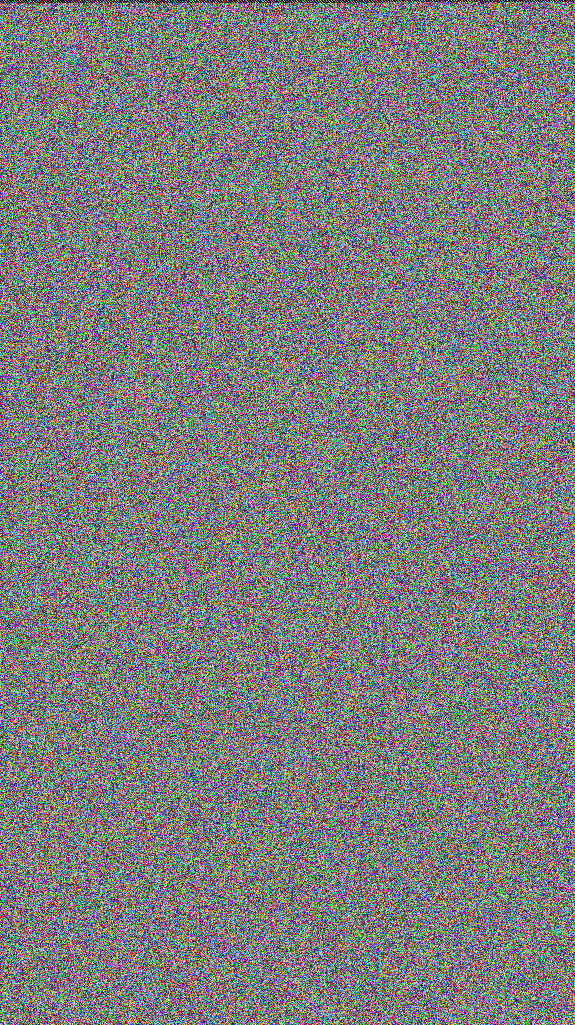

In [19]:
img

To make sure, we can listen to both versions, and like we would expect, the two audios are pretty much the same

Note: If the video length seems off (something like 27+ hours on a 7 second clip) don't panic, it happens sometimes. The audio will still play well and if it bugs you just restart the notebook and do it again.

In [15]:
from IPython.display import Audio
Audio(data, rate=sample_rate)

In [16]:
Audio(data2, rate=sample_rate)